In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from decimal import Decimal
import datetime
import logging

In [3]:
# tato cast musi ist do gui, kde sa vytvori log subor, a inak to bude pouzivat iba default config

def get_logger(pathname):
    """
    Create log file similar to Ilaps-GUI log file
    
    Parameters
    ----------
    pathname : str
    Path to a log file(.txt). If file doesn't exists it is created.
    """
    logging.basicConfig(level=logging.INFO,format='%(levelname)s (%(name)s): %(asctime)s >>> %(message)s', datefmt='%d-%b-%y %H:%M:%S', filename=pathname)
    logger = logging.getLogger("main")
    return logger

logger = get_logger('./Ilaps_log.txt')

In [4]:
logger.info('Starting new session.')

In [5]:
def get_timestamp(strTime):
    """format string time from iolite to timestamp"""
    return datetime.datetime.strptime(strTime, '%Y-%m-%d %H:%M:%S.%f')


def get_difference(start, now):
    """return time in seconds between 2 timestamps"""
    diff = now - start
    return diff.total_seconds()


def get_index(data, time):
    """return closest index of MS time given time in seconds"""
    for i in range(len(data.index)-1):
        if (data.index[i] <= time) and (data.index[i+1]>time):
                return i+1

def get_diff_lst(iolite):
    """return list of times in seconds from start to every start and end of laser ablation for spots"""
    lst = []
    for i in range(1,len(iolite['Timestamp'])-1):
        if (i-4)%5==0:
            lst.append(get_difference(get_timestamp(iolite.loc[i-2,'Timestamp']),get_timestamp(iolite.loc[i,'Timestamp'])))
            lst.append(get_difference(get_timestamp(iolite.loc[i,'Timestamp']),get_timestamp(iolite.loc[i+1,'Timestamp'])))
    lst.append(get_difference(get_timestamp(iolite.loc[i,'Timestamp']),get_timestamp(iolite.loc[i+1,'Timestamp'])))
    return lst

def get_diff_lst_line(iolite):
    """return list of times in seconds from start to every start and end of laser ablation for lines"""
    lst = []
    for i in range(1,len(iolite['Timestamp'])-1):
        if (i-6)%7==0:
            lst.append(get_difference(get_timestamp(iolite.loc[i-2,'Timestamp']),get_timestamp(iolite.loc[i,'Timestamp'])))
            lst.append(get_difference(get_timestamp(iolite.loc[i,'Timestamp']),get_timestamp(iolite.loc[i+1,'Timestamp'])))
    lst.append(get_difference(get_timestamp(iolite.loc[i-2,'Timestamp']),get_timestamp(iolite.loc[i,'Timestamp'])))
    return lst

def remove_outliers(data, offset, width):
    """
    Function to filter data by percentile value.
    
    Parameters
    ----------
    data: nparray
        array of data
    offset: float
        1-offset = upper treshold for percentile filtering. 
        Accepts values between 0 and 1.
    width: float
        Width od returned values, where 1-offset-width = lower treshold for percentile filtering.
        Accepts values between 0 and 1.

    Returns
    -------
    data_out : nparray
        Filtered data.
    """
    
    if offset<0 or 1<offset:
        raise ValueError(f'offset={offset}: Offset must be between 0 and 1')
        
    if width<0 or 1<width:
        raise ValueError(f'Width={width}: Width must be between 0 and 1') 
    
    upper, lower = np.percentile(data, [round(100*(1-offset),4), round(100*(1-offset-width),4)]) # round to clear float error
    
    data_out = np.array([x for x in data if x>= lower and x<=upper])
    
    return data_out


In [6]:
class DataReader():  
    """
    Reads data into pandas Dataframe from a file.

    Parameters
    ----------
    filetype : str
        Type of the file to read. If not specified, csv is used. 
        Possible options are csv, xlsx and asc.
    instrument : str
        Type of the instrument used for measurement. If not specified, raw data is expected. 
        Possible options are Agilent, and Element.

    Returns
    -------
    data : dataframe
        `data` as a dataframe, which can be passed to MSData.

    """
    def __init__(self, filename, filetype=None, instrument=None):
        
        self.filename = filename
        self.filetype = filetype
        self.instrument = instrument
        self.data = self.read(filename, filetype, instrument)
        
    def __call__(self):
        return self.data
        
    def read(self, filename, filetype, instrument):
        if instrument == 'Element':
            skipfooter = 4
            header = 1
            drop = 9
        elif instrument == 'Agilent':
            skipfooter = 4
            header = 3
            drop = 3
        else:
            skipfooter = 0
            header = 0
            drop = 0

        if filetype == 'xlsx':
            imported = pd.ExcelFile(filename)
            data = imported.parse(0, index_col=0, skipfooter=skipfooter, header=header)
            data = sdata.drop(data.index[:drop], axis=0)

        elif filetype == 'csv':
            data = pd.read_csv(filename, sep=',', index_col=0, skipfooter=skipfooter,
                                    header=header, engine='python')

        elif filetype == 'asc':
            data = pd.read_csv(filename, sep='\t', index_col=0, skipfooter=skipfooter,
                                    header=header, engine='python')
            data = data.drop(data.index[:drop], axis=0)
            data.dropna(axis=1, how='all', inplace=True)
            data = data.apply(pd.to_numeric, errors='coerce')

        else:
            warnings.warn('File type not supported.')

        return data
    

In [7]:
def plot_data(data, isotopes=None, ax=None, *args, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    if isotopes is not None:
        ax.plot(data[isotopes], *args, **kwargs)
    else:
        ax.plot(data, *args, **kwargs)
    

In [8]:
class Session():
    pass

In [9]:
class MSData():
    def __init__(self, datareader):
        self.datareader = datareader
        logger.info(f'Reading data {self.datareader.filename}.')
        self.data = self.datareader()
        self.time = np.array(self.data.index)
        self.matrix = self.data.values
        self.isotope_names = np.array(self.data.columns)
        self.isotopes = {}
        self.selector = None
        self.starts, self.ends = None, None
        self.laser_off, self.laser_on = None, None
        
    def __call__(self, isotopes=None, *args, **kwargs):
        plot_data(self.data, isotopes=isotopes, *args, **kwargs)
        
    def __repr__(self):
        res = f'{self.__class__.__name__}\n Analysis time: {self.time.max()}s\n File path: {self.datareader.filename}\n Measured isotopes: {self.isotope_names}'
        return res
    
    def time_to_number(self, time, integration_time=None):
        """
        takes time in seconds returns number of measured values
        depends on integration time of MS method
        """
        if not integration_time:
            integration_time = (d.time[2]-d.time[1])
        val = int(abs(time)//integration_time)
        if time < 0: val = -val
        return val
    
    def create_isotopes(self):
        for key in self.isotope_names:
            self.isotopes[key] = Isotope(key, self)
    
    def select(self, method='treshold', s=60, sdmul=10, iolite=None):
        self.selector = Selector(self, method=method, s=s, sdmul=sdmul, iolite=iolite)
        self.starts, self.ends = self.selector()
        self.laser_on, self.laser_off = self.selector.create_on_off(self.starts, self.ends)
        
    def graph(self, ax=None, logax=False, el=None):
        """
        create matplotlib graph of intensity in time for ablation
        highlights ablation part and background signal
        """
        if ax==None:
            fig,ax = plt.subplots()

        ax.cla()
        ax.clear()
        # if element is defined, plot only one element, otherwise all
        if el:
            self.data.plot(ax=ax, y=el, kind='line', legend=False)
        else:
            self.data.plot(ax=ax, kind='line', legend=False)

        if logax:
            ax.set_yscale('log')

        if self.starts and self.ends:
            # create lines for start and end of each ablation
            for i in range(0,len(self.starts)):
                ax.axvline(x=self.time[self.starts[i]], color='blue', linewidth=2)
            for i in range(0,len(self.ends)):
                ax.axvline(x=self.time[self.ends[i]], color='blue', linewidth=2)

        if self.laser_off :
            # higlights bacground
            for off in self.laser_off:
                #print(self.time[off[0]], self.time[off[1]])
                try:
                    ax.axvspan(self.time[off[0]], self.time[off[1]], alpha=0.2, color='red')
                except:
                    warnings.warn('something is wrong')

        
        if self.laser_on:
            # higlihts ablation
            for on in self.laser_on: 
                ax.axvspan(self.time[on[0]], self.time[on[1]], alpha=0.2, color='green')

        plt.show()
        
    

In [10]:
class Isotope():   
    """
    Extract specific Isotope data from MSData object.

    Parameters
    ----------
    isotope_name : str
        Isotope to extract from MSData (i.e. Li7)
    ms_data : MSData
        MS data to extract from.
        
    Returns
    -------
    data : array
        `data` interpreted as an array.

    """
    def __init__(self, isotope_name, ms_data, *args, **kwargs):
        self.isotope_name = isotope_name
        self.ms_data = ms_data
        self.isotope_number = int(''.join([c for c in self.isotope_name if c.isnumeric()]))
        self.data = ms_data.data[isotope_name].values
        self.despiked = None 
        self.bcg = None
        self.bcg_corrected = None
        #TODO use self.despiked as a state, in next functions if despiked is True, use that 
        # values if they exists, if not do despike if false use original 
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.data[idx]
        return [self.data[i] for i in idx]
    def __call__(self):
        plt.plot(self.data)
    def __repr__(self):
        res = f'{self.__class__.__name__} {self.isotope_name} ({len(self)} values)\n{self.data[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res
    def __iter__(self): return iter(self.data)
    def __setitem__(self, i, o): self.data[i] = o
    def __delitem__(self, i): del(self.data[i])
    
    def element(self):
        return ''.join([c for c in self.isotope_name if c.isalpha()])
    
    def despike(self, win=3, treshold=10):
        sig = pd.Series(self.data)
        skip = int((win-1)/2)
        outliers = np.zeros(len(sig), dtype=bool)
        outliers[skip:-skip] = True
        rm = np.array(sig.rolling(win).mean().dropna())
        rs = np.array(sig.rolling(win).std().dropna())**0.5
        outliers[skip:-skip] = sig[skip:-skip] > rm+rs*treshold
        sig[outliers] = rm[outliers[skip:-skip]]
        return sig
        
    def bcg_correction(self, method='beginning', despiked=False):
        
        possible_methods = ['all', 'beginning', 'end']
        assert method in possible_methods
        if not self.ms_data.laser_on:
            warnings.warn('Bacground correction requires selection of peaks first.')
        if not self.bcg:
            self.bcg = Background(self, self.ms_data.laser_on, self.ms_data.laser_off)
            
        if despiked==False:
            data = np.copy(self.data)
        else:
            if self.despiked is None:
                self.despiked = self.despike()
            data = np.copy(self.despiked)
        
        if method=='beginning':
            data_out = data-self.bcg.bcg_means[0]
            
        if method=='end':
            data_out = data-self.bcg.bcg_means[-1]
            
        if method=='all':
            data_out = data-self.bcg.bcg_interp
        
        data_out[data_out < 0] = 0   
        
        return data_out
                
        
        
    def peakiefy(self, laser_on, laser_off):
        pass
    
    
        

In [11]:
class Peak():
    def __init__(self, isotope, bounds, *args, **kwargs):
        if isotope.data is None:
            raise ValueError('Missing data for isotope: {}'.format(isotope.isotope_name))
        self.data = isotope.data[bounds[0]:bounds[1]]
    def __len__(self):
        return len(self.data)
    def __call__(self):
        plt.plot(self.data)
    def __repr__(self):
        pass 

In [12]:
class Background():
    def __init__(self, isotope, laser_on, laser_off, width=0.8, offset=0.15):
        assert isotope.data is not None
        self.bcg_all = [remove_outliers(isotope.data[laser_off[i][0]:laser_off[i][1]], offset, width) for i in range(len(laser_off))]
        self.bcg_means = [x.mean() for x in self.bcg_all]
        
        bcg_mskd = np.copy(isotope.data)
        for (s,e) in laser_on:
            bcg_mskd[s-2:e+2] = np.nan
        not_nan = np.logical_not(np.isnan(bcg_mskd ))
        indices = np.arange(len(bcg_mskd ))
        self.bcg_interp = np.interp(indices, indices[not_nan], bcg_mskd[not_nan])
            
    def __call__(self):
        plt.plot(self.bcg_means)
    def __repr__(self):
        return f'{self.__class__.__name__}: {self.bcg_means} '

In [13]:
class ElementalMap():
    def __init__(self, ms_data, isotope, laser_on, laser_off):
        pass
    def __len__(self):
        pass
    def __call__(self):
        plt.plot(self.bcg_means)
    def __repr__(self):
        pass 

In [14]:
class Iolite():
    def __init__(self, path):
        self.data = self.read_iolite(path)
        self.peak_names = self.names_from_iolite(self.data)
        
    def read_iolite(self, path):
        iolite = pd.read_csv(path, sep=",", engine='python')
        return iolite
        
    def names_from_iolite(self, iolite):
        names = list(iolite[' Comment'].dropna())
        return names
    

In [15]:
class Lase():
    pass

In [16]:
class Selector():
    def __init__(self, ms_data, method = 'treshold', s=60, sdmul=10, iolite=None):
        self.possible_methods = ('treshold','iolite')
        self.ms_data = ms_data
        self.filter_line = self.ms_data.data.sum(1)
        self.method = method
        self.iolite = iolite
        self.start = s
        self.sdmul = sdmul
        self.skip = {'bcg_start': 0,
                     'bcg_end': 0,
                     'sample_start': 0,
                     'sample_end': 0}    # time in seconds to skip from each bcg and sample
        
    def __call__(self):
        if self.method not in self.possible_methods:
            warnings.warn(f'{self.method} not implemented.\n Select from: {self.possible_methods}')
            return  
        elif self.method == 'treshold':
            return self.create_selector_treshold()
        elif self.method == 'iolite':
            return self.create_selector_iolite()
        
    
    def create_selector_iolite(self):
        """select starts and ends of ablation using iolite file """ 
        logger.info('Selecting peak bounds by iolite.')
        
        lst = [x for x in self.iolite.data.loc[:6, ' Comment'] if isinstance(x, str)]
        
        if len(lst) == 2:
            logger.info('Selecting spots.')
            difflst = get_diff_lst(self.iolite.data)
        elif len(lst) == 1:
            logger.info('Selecting lines.')
            difflst = get_diff_lst_line(self.iolite.data)
        else:
            logger.error('Iolite selection failed.')
            
        timeindex = []
        for i in range(0, len(difflst)+1):
            timeindex.append(sum(difflst[:i])+self.start)
        index =[get_index(self.ms_data.data, x) for x in timeindex]
        
        starts = [index[i] for i in range(len(index)) if i %2==0]
        ends = [index[i]+1 for i in range(len(index)) if i %2!=0]
        
        return starts, ends
    
    def create_selector_treshold(self):
        """
        select starts and ends of ablation based on selected element or sum of all using treshold
        calculated from background
        """
        logger.info('Selecting peak bounds by setting treshold.')
        bcg_nr = self.ms_data.time_to_number(self.start)
        bcg = self.filter_line[0:bcg_nr].mean()
        std = self.filter_line[0:bcg_nr].std()
        ind = [True if value > bcg+self.sdmul*std else False for value in self.filter_line]
        ind2 = ind[1:]; ind2.append(False)
        index = [i for i in range(0,len(ind)) if ind[i]!=ind2[i]]
        
        starts = [index[i] for i in range(len(index)) if i %2==0]
        ends = [index[i] for i in range(len(index)) if i %2!=0]
        
        return starts, ends
    
    def set_skip(self, bcg_s=None, bcg_e=None, sig_s=None, sig_e=None):
        """
        set time skipped on start and end of background and ablation in seconds
        """
        if bcg_s is not None:
            self.skip ['bcg_start'] = bcg_s
        if bcg_e is not None:
            self.skip ['bcg_end'] = bcg_e
        if sig_s is not None:
            self.skip ['sample_start'] = sig_s
        if sig_e is not None:
            self.skip ['sample_end'] = sig_e
    
    def create_on_off(self, starts, ends):
        """
        from starts and ends of ablation create laser_on and laser_off with skipped values
        """
        laser_off = []
        laser_on = []

        laser_off.append((0+self.ms_data.time_to_number(self.skip['bcg_start']),starts[0]-self.ms_data.time_to_number(self.skip['bcg_end'])))
        
        for i in range(len(starts)-1):
            laser_off.append((ends[i]+self.ms_data.time_to_number(self.skip['bcg_start']), starts[i+1]-self.ms_data.time_to_number(self.skip['bcg_end'])))
            laser_on.append((starts[i]+self.ms_data.time_to_number(self.skip['sample_start']), ends[i]-self.ms_data.time_to_number(self.skip['sample_end'])))
        
        laser_off.append((ends[-1]+self.ms_data.time_to_number(self.skip['bcg_start']), len(self.ms_data.time)-2-self.ms_data.time_to_number(self.skip['bcg_end'])))
        laser_on.append((starts[-1]+self.ms_data.time_to_number(self.skip['sample_start']), ends[-1]-self.ms_data.time_to_number(self.skip['sample_end'])))
        return laser_on, laser_off
        



In [17]:
class Quantifier():
    pass

In [18]:
reader = DataReader(filename='/Users/nikadilli/code/Ilaps/test_data/an1.csv', filetype='csv', instrument='Agilent')

In [19]:
d = MSData(reader)


In [20]:
io = Iolite('/Users/nikadilli/code/Ilaps/test_data/an1.Iolite.csv')
io.data

,Timestamp,Sequence Number,SubPoint Number,Vertix Number,Comment,X,Y,Intended X,Intended Y,Scan Velocity,Laser State,Laser Rep. Rate,Spot Type,Spot Size,Spot Angle,MFC1,MFC2,Cell Pressure,Fluence At Sample
0,2020-02-28 12:06:00.540,1.0,1.0,NaN,NIST610,55678,47276,NaN,NaN,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN
1,2020-02-28 12:06:00.540,NaN,NaN,NaN,NaN,55678,47276,NaN,NaN,0.0,Off,0,Slit,65 x 65,0,0,0,0,NaN
2,2020-02-28 12:06:00.540,NaN,NaN,NaN,NaN,55678,47276,55678.0,47276.0,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN
3,2020-02-28 12:06:00.780,NaN,NaN,NaN,NaN,55678,47276,NaN,NaN,NaN,On,20,Slit,65 x 65,0,0,0,0,NaN
4,2020-02-28 12:07:01.606,NaN,NaN,NaN,NaN,55678,47276,NaN,NaN,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN
5,2020-02-28 12:08:03.624,2.0,1.0,NaN,NIST610,55769,47431,NaN,NaN,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN
6,2020-02-28 12:08:03.624,NaN,NaN,NaN,NaN,55769,47431,NaN,NaN,0.0,Off,0,Slit,65 x 65,0,0,0,0,NaN
7,2020-02-28 12:08:03.624,NaN,NaN,NaN,NaN,55769,47431,55769.0,47431.0,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN
8,2020-02-28 12:08:03.720,NaN,NaN,NaN,NaN,55769,47431,NaN,NaN,NaN,On,20,Slit,65 x 65,0,0,0,0,NaN
9,2020-02-28 12:09:04.519,NaN,NaN,NaN,NaN,55769,47431,NaN,NaN,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN


In [21]:
d.create_isotopes()

In [22]:
d.select(method='iolite', s=117, sdmul=30, iolite=io)

<IPython.core.display.Javascript object>


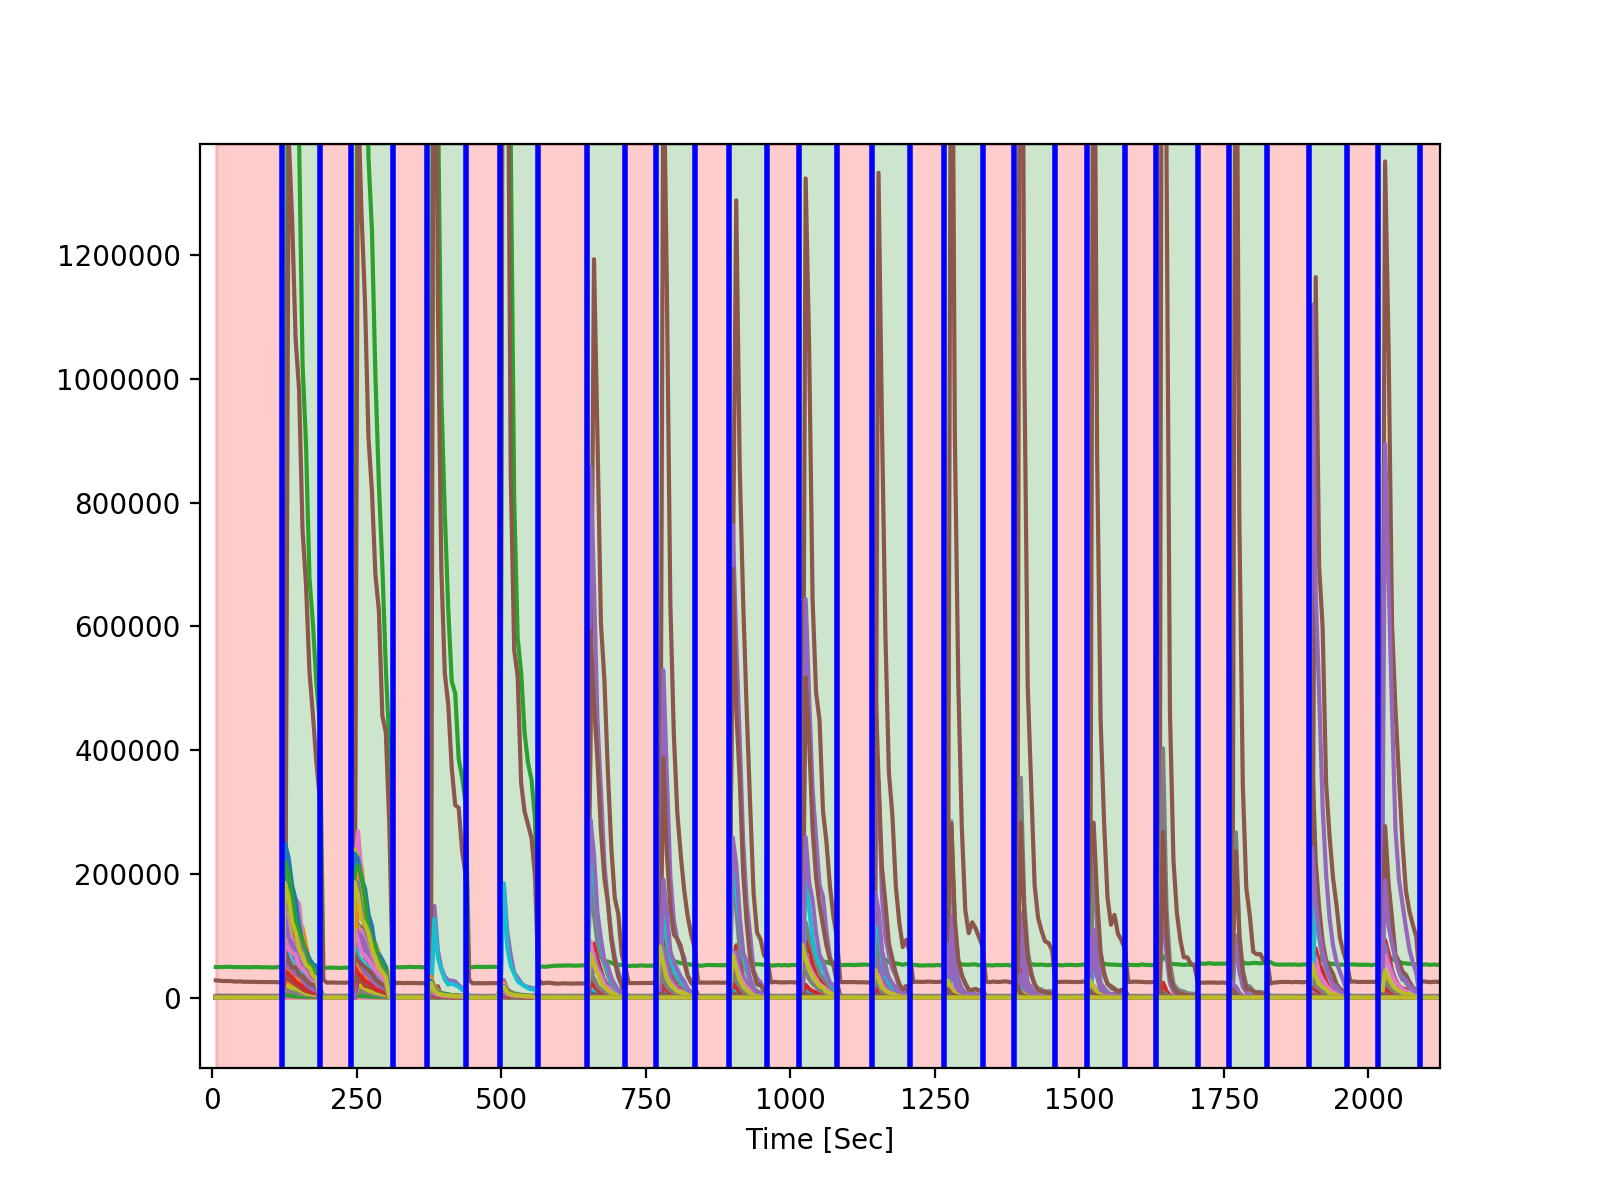

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
d.graph(ax=ax)

In [30]:
bcg = Background(d.isotopes['Li7'], d.laser_on, d.laser_off)

<IPython.core.display.Javascript object>


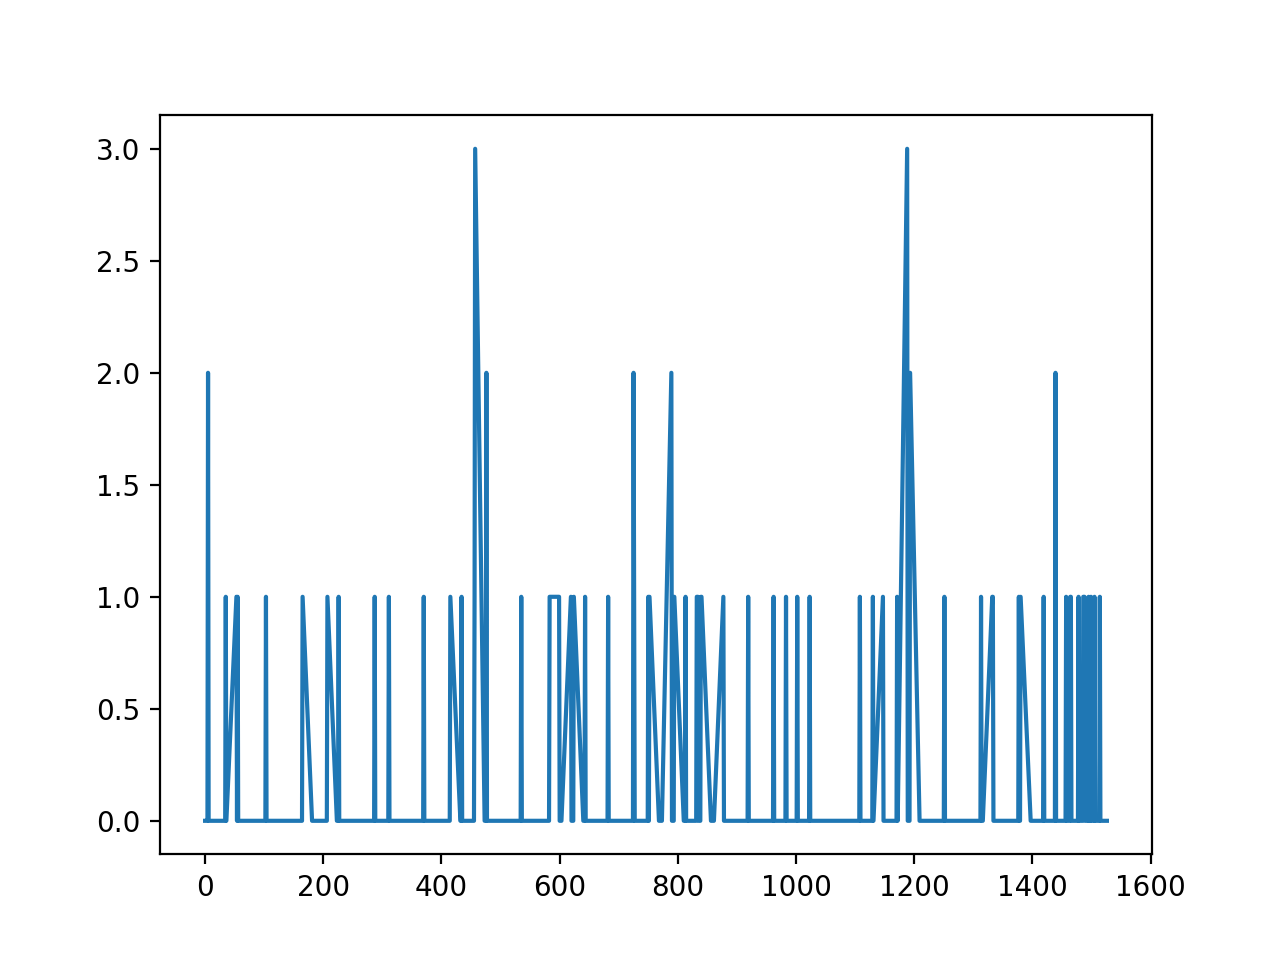

In [31]:
plt.plot(bcg.bcg_interp)

In [252]:
bcg.bcg_all[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<IPython.core.display.Javascript object>


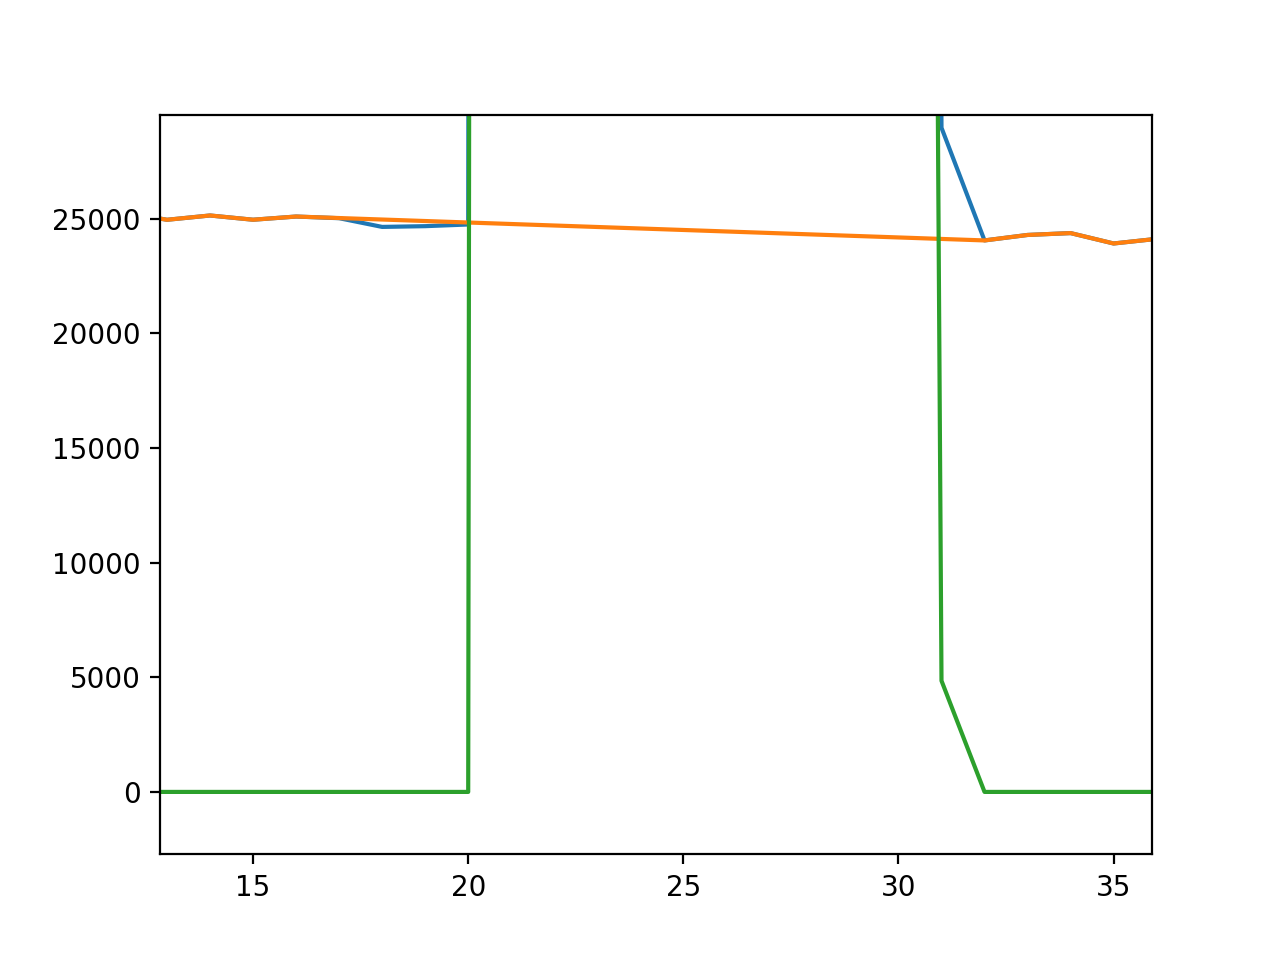

In [24]:
plt.plot(d.isotopes['Si28'])

In [186]:
plt.plot(d.isotopes['Si28'].despike())

In [28]:
plt.plot(d.isotopes['Si28'].bcg_correction(method='all'))

In [193]:
d.isotopes['Si28'].bcg_correction()

array([2235.04, 1797.13, 1087.56, ...,    0.  ,    0.  ,    0.  ])

In [261]:
l = np.copy(d.isotopes['Si28'].data)
l

array([27750.01, 27312.1 , 26602.53, ..., 12574.42, 12776.11, 12654.08])

In [262]:
for (s,e) in laser_on:
    l[s-2:e+2] = np.nan

In [264]:
l[15]

24949.52

In [265]:

not_nan = np.logical_not(np.isnan(l))
indices = np.arange(len(l))
new = np.interp(indices, indices[not_nan], l[not_nan])

<IPython.core.display.Javascript object>


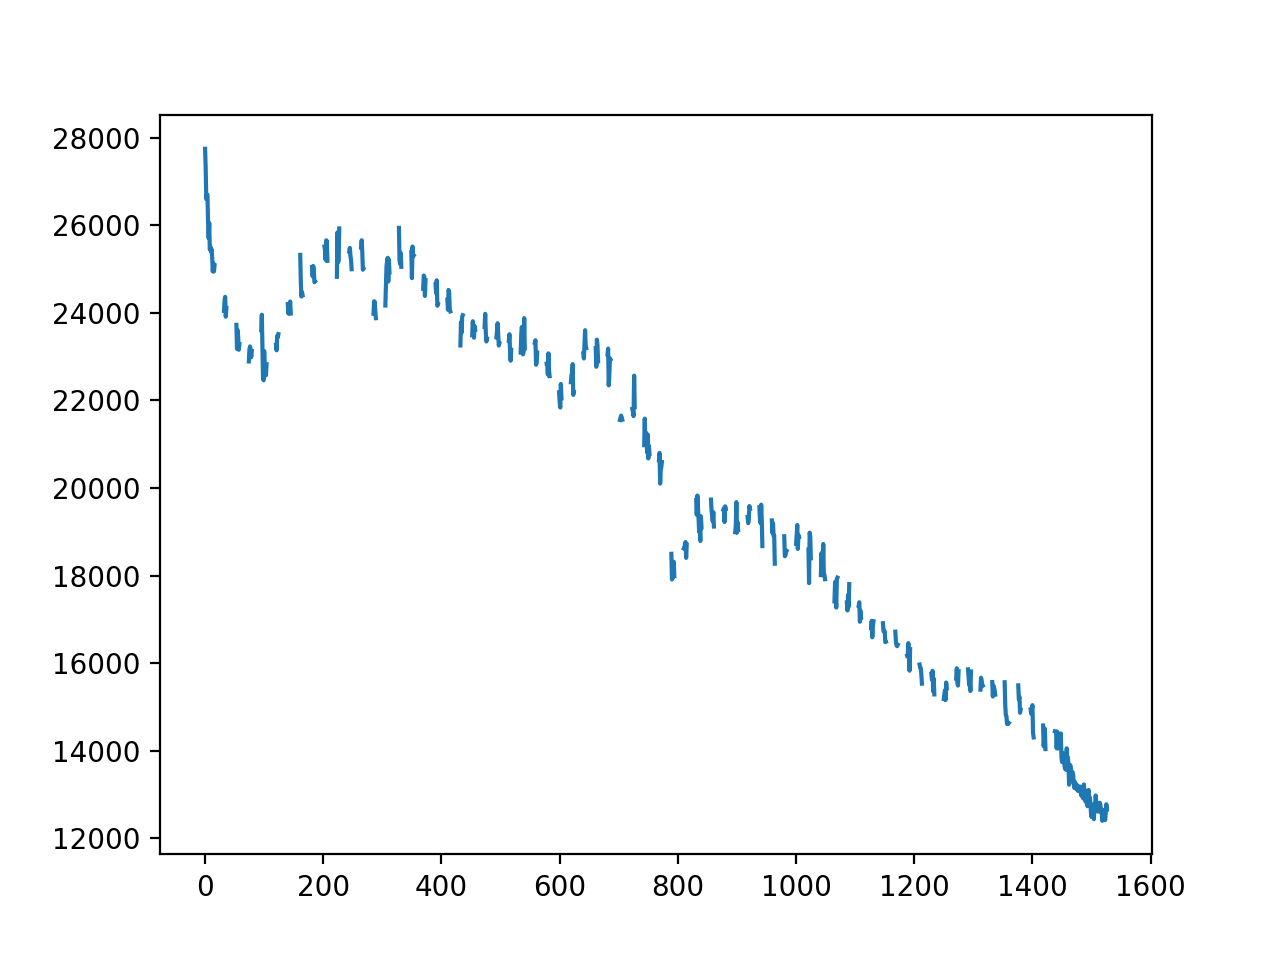

In [267]:
plt.plot(l)

In [277]:
plt.plot(d.isotopes['Si28'].data)

In [279]:
corected = d.isotopes['Si28'].data - bcg.bcg_interp

<IPython.core.display.Javascript object>


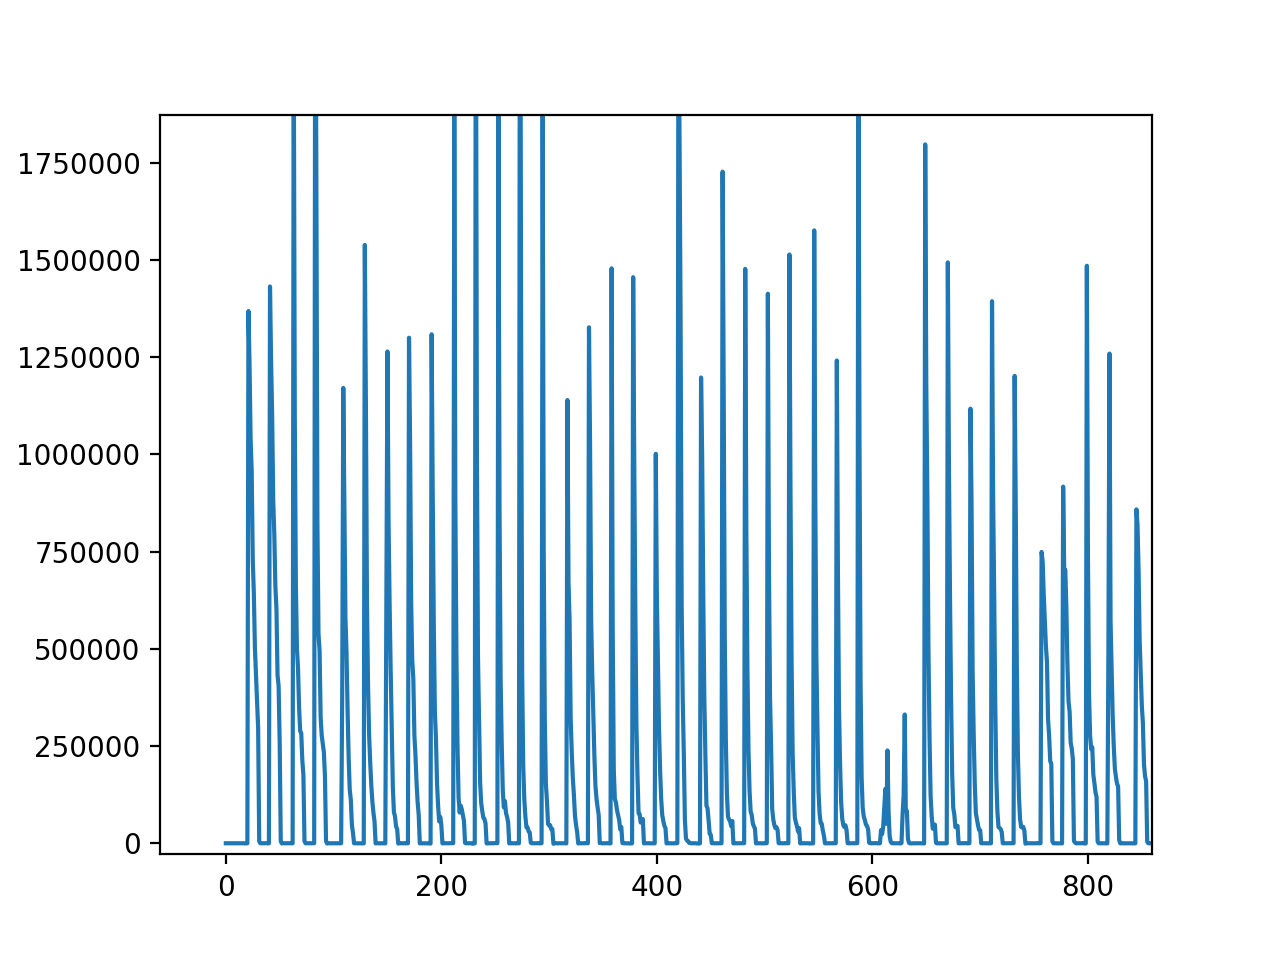

In [283]:
plt.plot(corected)